# Mean Reverse Research 1

This research will examing the condition when mean reverse happening and also we are interested in the during of mean reverse happens and the matrics it happens (how far from the moving average)

Important Concepts:
    1. PM-Delta: The difference between price and moving average; 
    2. P-Delta: The difference between target time price and current price;
    3. Q500US: A universe of securities that defined as easy tradable 500 securities [reference](https://www.quantopian.com/posts/the-q500us-and-q1500us.)
    4. sma: Simple moving average;
    5. lsma: Simple moving average of yesterday

### Dependent Variable

Up or Down: Positive value or Negative value of the p-delta

## Independent Variables

PM-Delta: Difference between current price and the 30 days moving average.

## Data

#### Q1500US universe mask

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

In [5]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.classifiers.morningstar import Sector


SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
}


class OneDayPDelta(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 2
    
    def compute(self, today, assets, out, close):
        out[:] = close[1] - close[0]

        
class LSimpleMovingAverage(SimpleMovingAverage):
    """
    Average Value of an arbitrary column

    **Default Inputs**: None

    **Default Window Length**: None
    """
    # numpy's nan functions throw warnings when passed an array containing only
    # nans, but they still returns the desired value (nan), so we ignore the
    # warning.

    def compute(self, today, assets, out, data):
        out[:] = np.nanmean(data[0:self.window_length - 1], axis=0)

        
class LastClose(CustomFactor):
    windown_length = 2
    def compute(self, today, assets, out, data):
        out[:] = data[0]

        
def get_data(start, end):
    """
    Get the USEquityPricing data masked by the Q1500US universe.
    Args:
        start: start date interested in.
        end: end date interested in.
    """
    pipe = Pipeline(
        columns={'close': USEquityPricing.close.latest,
                 'last_close': LastClose(inputs=[USEquityPricing.close], window_length=2),
                 'lsma10': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=11),
                 'lsma15': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=16),
                 'lsma20': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=21),
                 'lsma25': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=26),
                 'lsma30': LSimpleMovingAverage(inputs=[USEquityPricing.close], window_length=31),
                 'sma30': SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30),
                 'pdelta1': OneDayPDelta(inputs=[USEquityPricing.close], window_length=2),
                 'sector': Sector()},
        screen=Q1500US()
    )

    research_range = (start, end)
    data = run_pipeline(pipe, *research_range)
    
    return data

data = get_data('2008-01-01', '2008-01-01').head()
data

close  last_close    lsma10  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    36.54       36.81   35.7972   
                          Equity(24 [AAPL])  198.08      199.78  191.7642   
                          Equity(62 [ABT])    56.02       57.16   57.5550   
                          Equity(67 [ADSK])   49.75       50.19   50.1130   
                          Equity(76 [TAP])    51.64       52.12   51.8885   

                                                 lsma15     lsma20  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    36.135467   36.02910   
                          Equity(24 [AAPL])  191.827467  189.68860   
                          Equity(62 [ABT])    57.823333   57.78350   
                          Equity(67 [ADSK])   49.864667   49.35200   
                          Equity(76 [TAP])    52.458333   52.97625   

                                                 lsma25      lsma30  pdelta1  \
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])    35.939280   35.891067    -0.27   
                          Equity(24 [AAPL])  187.083400  183.624867    -1.70   
                          Equity(62 [ABT])    57.388400   56.980333    -1.14   
                          Equity(67 [ADSK])   48.692000   48.298667    -0.44   
                          Equity(76 [TAP])    52.866496   52.644375    -0.48   

                                             sector       sma30  
2008-01-02 00:00:00+00:00 Equity(2 [ARNC])      101   35.897067  
                          Equity(24 [AAPL])     311  184.752667  
                          Equity(62 [ABT])      206   57.032000  
                          Equity(67 [ADSK])     311   48.370000  
                          Equity(76 [TAP])      205   52.626050

## Step 1. Correlation between P-Delta and PM-Delta

### Fetch and validate data

In [6]:
data1 = get_data(start = '2014-01-01', end = '2017-01-01')

data1.head()

close  last_close    lsma10  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])    10.63       10.53   10.1175   
                          Equity(24 [AAPL])  561.16      554.50  557.2660   
                          Equity(62 [ABT])    38.34       38.40   37.8840   
                          Equity(67 [ADSK])   50.32       49.58   48.7840   
                          Equity(76 [TAP])    56.15       55.76   54.9740   

                                                 lsma15     lsma20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.894333    9.77170   
                          Equity(24 [AAPL])  558.746667  559.58850   
                          Equity(62 [ABT])    37.496000   37.50050   
                          Equity(67 [ADSK])   48.028000   47.51350   
                          Equity(76 [TAP])    54.691333   54.50925   

                                                 lsma25      lsma30  pdelta1  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.727560    9.615300     0.10   
                          Equity(24 [AAPL])  554.830800  548.996333     6.66   
                          Equity(62 [ABT])    37.639600   37.731500    -0.06   
                          Equity(67 [ADSK])   47.100000   46.436000     0.74   
                          Equity(76 [TAP])    54.221354   54.074253     0.39   

                                             sector       sma30  
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      101    9.668967  
                          Equity(24 [AAPL])     311  550.203667  
                          Equity(62 [ABT])      206   37.740833  
                          Equity(67 [ADSK])     311   46.643000  
                          Equity(76 [TAP])      205   54.152720

In [8]:
data1.loc['2014-01-03'].head()

close  last_close   lsma10  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])    10.529       10.63   10.224   
                          Equity(24 [AAPL])  553.230      561.16  557.635   
                          Equity(62 [ABT])    38.240       38.34   38.064   
                          Equity(67 [ADSK])   49.250       50.32   49.098   
                          Equity(76 [TAP])    55.220       56.15   55.215   

                                                 lsma15     lsma20     lsma25  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.971667    9.82525    9.78316   
                          Equity(24 [AAPL])  558.384000  560.08150  556.48960   
                          Equity(62 [ABT])    37.571333   37.51000   37.64320   
                          Equity(67 [ADSK])   48.263333   47.75800   47.27840   
                          Equity(76 [TAP])    54.764667   54.68975   54.33460   

                                                 lsma30  pdelta1  sector  \
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.668967   -0.101     101   
                          Equity(24 [AAPL])  550.203667   -7.930     311   
                          Equity(62 [ABT])    37.740833   -0.100     206   
                          Equity(67 [ADSK])   46.643000   -1.070     311   
                          Equity(76 [TAP])    54.152720   -0.930     205   

                                                  sma30  
2014-01-03 00:00:00+00:00 Equity(2 [ARNC])     9.721933  
                          Equity(24 [AAPL])  551.356333  
                          Equity(62 [ABT])    37.750667  
                          Equity(67 [ADSK])   46.840667  
                          Equity(76 [TAP])    54.204825

In [9]:
data1['pm_delta30'] = data1.last_close - data1.lsma30
data1['pm_delta25'] = data1.last_close - data1.lsma25
data1['pm_delta20'] = data1.last_close - data1.lsma20
data1['pm_delta15'] = data1.last_close - data1.lsma15
data1['pm_delta10'] = data1.last_close - data1.lsma10

data1.head()

close  last_close    lsma10  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])    10.63       10.53   10.1175   
                          Equity(24 [AAPL])  561.16      554.50  557.2660   
                          Equity(62 [ABT])    38.34       38.40   37.8840   
                          Equity(67 [ADSK])   50.32       49.58   48.7840   
                          Equity(76 [TAP])    56.15       55.76   54.9740   

                                                 lsma15     lsma20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.894333    9.77170   
                          Equity(24 [AAPL])  558.746667  559.58850   
                          Equity(62 [ABT])    37.496000   37.50050   
                          Equity(67 [ADSK])   48.028000   47.51350   
                          Equity(76 [TAP])    54.691333   54.50925   

                                                 lsma25      lsma30  pdelta1  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     9.727560    9.615300     0.10   
                          Equity(24 [AAPL])  554.830800  548.996333     6.66   
                          Equity(62 [ABT])    37.639600   37.731500    -0.06   
                          Equity(67 [ADSK])   47.100000   46.436000     0.74   
                          Equity(76 [TAP])    54.221354   54.074253     0.39   

                                             sector       sma30  pm_delta30  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      101    9.668967    0.914700   
                          Equity(24 [AAPL])     311  550.203667    5.503667   
                          Equity(62 [ABT])      206   37.740833    0.668500   
                          Equity(67 [ADSK])     311   46.643000    3.144000   
                          Equity(76 [TAP])      205   54.152720    1.685747   

                                             pm_delta25  pm_delta20  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     0.802440     0.75830   
                          Equity(24 [AAPL])   -0.330800    -5.08850   
                          Equity(62 [ABT])     0.760400     0.89950   
                          Equity(67 [ADSK])    2.480000     2.06650   
                          Equity(76 [TAP])     1.538646     1.25075   

                                             pm_delta15  pm_delta10  
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])     0.635667      0.4125  
                          Equity(24 [AAPL])   -4.246667     -2.7660  
                          Equity(62 [ABT])     0.904000      0.5160  
                          Equity(67 [ADSK])    1.552000      0.7960  
                          Equity(76 [TAP])     1.068667      0.7860

### Run Coorelation

In [10]:
data1.iloc[:, (7, 9, 10, 11, 12,13)].corr()

,pdelta1,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15
pdelta1,1.000000,0.007460,-0.012450,-0.012134,-0.012598,-0.009773
sma30,0.007460,1.000000,0.075233,0.063346,0.051875,0.039926
pm_delta30,-0.012450,0.075233,1.000000,0.988041,0.948870,0.875503
pm_delta25,-0.012134,0.063346,0.988041,1.000000,0.982310,0.923327
pm_delta20,-0.012598,0.051875,0.948870,0.982310,1.000000,0.971610
pm_delta15,-0.009773,0.039926,0.875503,0.923327,0.971610,1.000000


In [11]:
data1 = data1.reset_index().rename(columns = {'level_0': 'date', 'level_1': 'asset'}).set_index('date')
data1.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(2 [ARNC]),10.63,10.53,10.1175,9.894333,9.77170,9.727560,9.615300,0.10,101,9.668967,0.914700,0.802440,0.75830,0.635667,0.4125
2014-01-02 00:00:00+00:00,Equity(24 [AAPL]),561.16,554.50,557.2660,558.746667,559.58850,554.830800,548.996333,6.66,311,550.203667,5.503667,-0.330800,-5.08850,-4.246667,-2.7660
2014-01-02 00:00:00+00:00,Equity(62 [ABT]),38.34,38.40,37.8840,37.496000,37.50050,37.639600,37.731500,-0.06,206,37.740833,0.668500,0.760400,0.89950,0.904000,0.5160
2014-01-02 00:00:00+00:00,Equity(67 [ADSK]),50.32,49.58,48.7840,48.028000,47.51350,47.100000,46.436000,0.74,311,46.643000,3.144000,2.480000,2.06650,1.552000,0.7960
2014-01-02 00:00:00+00:00,Equity(76 [TAP]),56.15,55.76,54.9740,54.691333,54.50925,54.221354,54.074253,0.39,205,54.152720,1.685747,1.538646,1.25075,1.068667,0.7860


In [12]:
assets_corr = data1.groupby('asset').corr()
assets_corr = assets_corr.iloc[:, 8:13].reset_index().groupby('asset').nth(7)
assets_corr.head()

,level_1,pm_delta10,pm_delta15,pm_delta20,pm_delta25,pm_delta30
asset,,,,,,
Equity(2 [ARNC]),pdelta1,0.007970,-0.033302,-0.055749,-0.050893,-0.043424
Equity(24 [AAPL]),pdelta1,0.056907,0.007019,0.014961,0.029938,0.033528
Equity(41 [ARCB]),pdelta1,-0.044572,-0.058633,-0.075225,-0.078209,-0.079200
Equity(52 [ABM]),pdelta1,NaN,NaN,NaN,NaN,NaN
Equity(53 [ABMD]),pdelta1,-0.055310,-0.066701,-0.076942,-0.077401,-0.068628


In [13]:
assets_corr.sort_values(['pm_delta10', 'pm_delta15', 'pm_delta20', 'pm_delta25', 'pm_delta30'])

,level_1,pm_delta10,pm_delta15,pm_delta20,pm_delta25,pm_delta30
asset,,,,,,
Equity(5783 [PBY]),pdelta1,-0.958503,-0.984448,-0.975417,0.271947,0.298533
Equity(50309 [COTY_WI]),pdelta1,-0.923267,-0.923267,-0.923267,-0.923267,-0.923267
Equity(49229 [KHC]),pdelta1,-0.770153,-0.882132,-0.762587,-0.842535,-0.842535
Equity(39171 [MSGN]),pdelta1,-0.645648,-0.650961,-0.648527,-0.644930,-0.640588
Equity(28667 [BDBD]),pdelta1,-0.643231,-0.616072,-0.602539,-0.613100,-0.142972
Equity(49751 [AVXS]),pdelta1,-0.624308,-0.467493,-0.432097,-0.388091,-0.291863
Equity(27480 [HITT]),pdelta1,-0.592387,-0.595285,0.105939,0.006646,-0.026082
Equity(15064 [AFFX]),pdelta1,-0.544969,-0.541035,-0.376368,-0.281517,-0.235724
Equity(35640 [IPCM]),pdelta1,-0.535124,-0.590468,-0.654324,-0.678303,-0.645446


Get the top 50 securities that has strongest mean reverse effect in 30 days

In [14]:
import matplotlib.pyplot as plt

In [15]:
data1.asset[0]

Equity(2, symbol=u'ARNC', asset_name=u'ARCONIC INC', exchange=u'NYSE', start_date=Timestamp('2002-01-01 00:00:00+0000', tz='UTC'), end_date=Timestamp('2017-06-12 00:00:00+0000', tz='UTC'), first_traded=None, auto_close_date=Timestamp('2017-06-15 00:00:00+0000', tz='UTC'), exchange_full=u'NEW YORK STOCK EXCHANGE')

In [16]:
t = data1[data1.asset == symbols('T')]
t.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(6653 [T]),35.15,35.180000,34.63660,34.475733,34.502300,34.669840,34.806533,-0.030000,308,34.797533,0.373467,0.510160,0.677700,0.704267,0.543400
2014-01-03 00:00:00+00:00,Equity(6653 [T]),34.95,35.150000,34.73560,34.506067,34.518800,34.659440,34.797533,-0.200000,308,34.775200,0.352467,0.490560,0.631200,0.643933,0.414400
2014-01-06 00:00:00+00:00,Equity(6653 [T]),34.81,34.950000,34.84660,34.542733,34.529800,34.642640,34.775200,-0.140000,308,34.744867,0.174800,0.307360,0.420200,0.407267,0.103400
2014-01-07 00:00:00+00:00,Equity(6653 [T]),34.94,34.810000,34.88660,34.600733,34.540800,34.623440,34.744867,0.130000,308,34.729867,0.065133,0.186560,0.269200,0.209267,-0.076600
2014-01-08 00:00:00+00:00,Equity(6653 [T]),34.49,34.480132,34.47579,34.214409,34.119738,34.149186,34.272764,0.009868,308,34.261251,0.207368,0.330946,0.360393,0.265723,0.004342


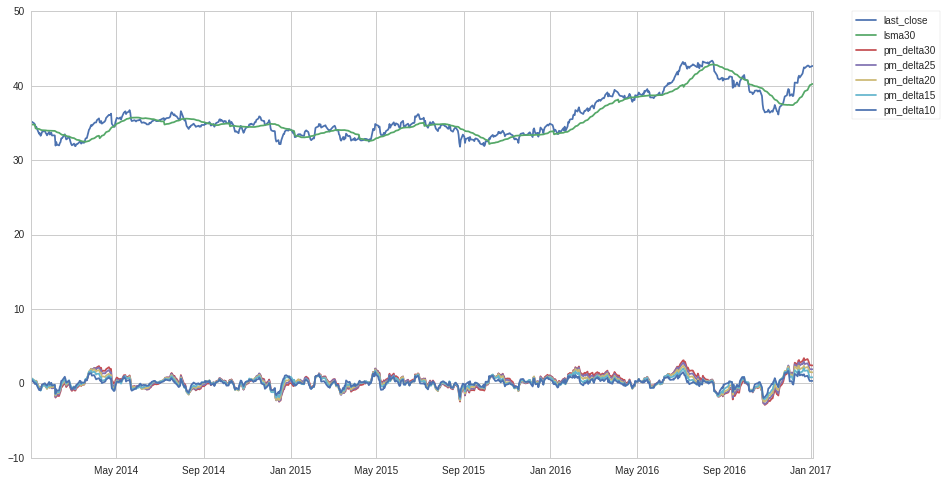

In [17]:
plt.plot(t.last_close)
plt.plot(t.lsma30)
plt.plot(t.pm_delta30)
plt.plot(t.pm_delta25)
plt.plot(t.pm_delta20)
plt.plot(t.pm_delta15)
plt.plot(t.pm_delta10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [18]:
aapl = data1[data1.asset == symbols('AAPL')]
aapl.head()

,asset,close,last_close,lsma10,lsma15,lsma20,lsma25,lsma30,pdelta1,sector,sma30,pm_delta30,pm_delta25,pm_delta20,pm_delta15,pm_delta10
date,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,Equity(24 [AAPL]),561.160,554.500,557.2660,558.746667,559.58850,554.83080,548.996333,6.660,311,550.203667,5.503667,-0.33080,-5.08850,-4.246667,-2.7660
2014-01-03 00:00:00+00:00,Equity(24 [AAPL]),553.230,561.160,557.6350,558.384000,560.08150,556.48960,550.203667,-7.930,311,551.356333,10.956333,4.67040,1.07850,2.776000,3.5250
2014-01-06 00:00:00+00:00,Equity(24 [AAPL]),541.040,553.230,557.4600,557.556667,559.42400,557.66880,551.356333,-12.190,311,552.074333,1.873667,-4.43880,-6.19400,-4.326667,-4.2300
2014-01-07 00:00:00+00:00,Equity(24 [AAPL]),543.949,541.040,556.4890,556.216667,558.23300,557.96640,552.074333,2.909,311,553.038967,-11.034333,-16.92640,-17.19300,-15.176667,-15.4490
2014-01-08 00:00:00+00:00,Equity(24 [AAPL]),540.030,543.949,556.4389,555.101933,557.02545,557.88916,553.038967,-3.919,311,553.672633,-9.089967,-13.94016,-13.07645,-11.152933,-12.4899


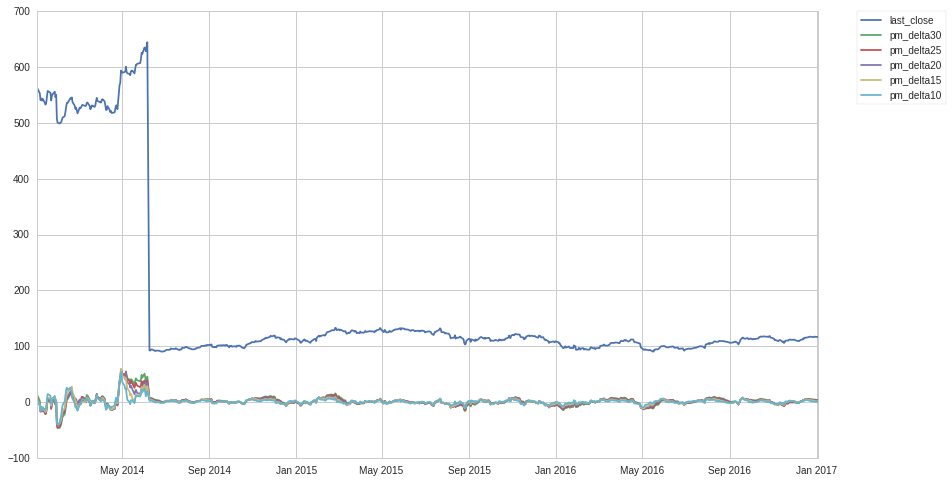

In [19]:
plt.plot(aapl.last_close)
plt.plot(aapl.pm_delta30)
plt.plot(aapl.pm_delta25)
plt.plot(aapl.pm_delta20)
plt.plot(aapl.pm_delta15)
plt.plot(aapl.pm_delta10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Step 2: Check the distribution of sectors

In [42]:
def calculate_sector_counts(sectors):
    counts = (sectors.groupby('sector').size())

    # Replace numeric sector codes with human-friendly names.
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts


def plot_sector_counts(sector_counts):
    ax = sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
    )
    ax.set_title('High PM-Delta vs. P-Delta Correlation Sector Breakdown', fontsize=18)
    ax.set_ylabel('')  # This overwrites default ylabel, which is the string None :(.

In [38]:
high_corr_asset = pd.merge(assets_corr.reset_index().iloc[:, 0:1].head(1000), 
                           data1.loc[:, ['asset', 'sector']], how='left', on = 'asset').groupby('asset').first()

high_corr_asset

,sector
asset,
Equity(2 [ARNC]),101
Equity(24 [AAPL]),311
Equity(41 [ARCB]),310
Equity(52 [ABM]),310
Equity(53 [ABMD]),206
Equity(62 [ABT]),206
Equity(67 [ADSK]),311
Equity(76 [TAP]),205
Equity(88 [ACI]),101


In [39]:
sector_counts = calculate_sector_counts(high_corr_asset)
sector_counts

Basic Materials            61
Consumer Cyclical         158
Financial Services        115
Real Estate                68
Consumer Defensive         61
Healthcare                110
Utilities                  46
Communication Services     13
Energy                     65
Industrials               166
Technology                137
dtype: int64

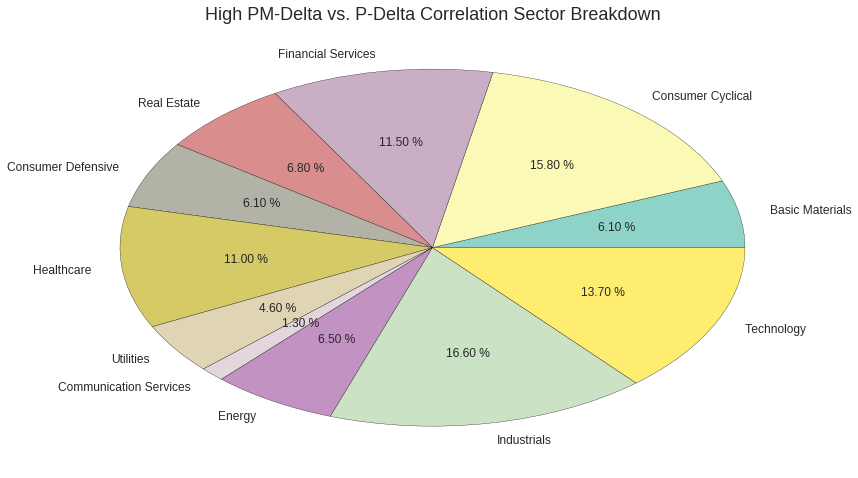

In [43]:
plot_sector_counts(sector_counts)

## Classification Model

Take apple's stock as an example and building a SVM classification model to check

In [48]:
from sklearn import svm
from sklearn import metrics

In [60]:
train = aapl.loc['2008-01-02': '2016-01-02']
test = aapl.loc['2016-01-03': '2017-01-01']

train_x = np.transpose(train[['pm_delta30', 'pm_delta25', 'pm_delta20', 'pm_delta15', 'pm_delta10']].as_matrix())
train_y = np.where(train['pdelta1'] > 0, 1, 0)

test_x = test[['pm_delta30', 'pm_delta25', 'pm_delta20', 'pm_delta15', 'pm_delta10']].as_matrix()
test_y = np.where(test['pdelta1'] > 0, 1, 0)

In [61]:
train_x

array([[ 16.15513333,  13.32733333,   9.22366667, ...,  -6.36466667,
         -7.27733333,  -5.23766667],
       [ 12.6966    ,   9.9326    ,   5.88836   , ...,  -6.3156    ,
         -7.0472    ,  -4.7048    ],
       [ 10.0914    ,   7.5949    ,   3.6474    , ...,  -5.264     ,
         -5.924     ,  -3.5225    ],
       [  7.95253333,   5.99786667,   2.7972    , ...,  -4.02733333,
         -4.424     ,  -1.86866667],
       [  8.0158    ,   5.5458    ,   1.3508    , ...,  -1.322     ,
         -1.896     ,   0.395     ]])

In [62]:
train_x = train_x.reshape(2015, 5)
test_x = test_x.reshape(252, 5)

In [63]:
test_x.shape

(252, 5)

In [64]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_x, train_y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [65]:
test_predict = clf.predict(test_x)

In [66]:
metrics.accuracy_score(test_y, test_predict)

0.48015873015873017

In [82]:
train = t.loc['2008-01-02': '2016-01-02']
test = t.loc['2016-01-03': '2017-01-01']

train_x = train[['pm_delta30', 'pm_delta25', 'pm_delta20', 'pm_delta15', 'pm_delta10']].as_matrix()
train_y = np.where(train['pdelta1'] > 0, 1, 0)

test_x = test[['pm_delta30', 'pm_delta25', 'pm_delta20', 'pm_delta15', 'pm_delta10']].as_matrix()
test_y = np.where(test['pdelta1'] > 0, 1, 0)

print train_x.shape
print test_x.shape

(2015, 5)
(252, 5)


In [83]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_x, train_y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [84]:
test_predict = clf.predict(test_x)
metrics.accuracy_score(test_y, test_predict)

0.51587301587301593